In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from scipy import stats,optimize
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from scipy.stats import jarque_bera,zscore

import requests
import json

/home/robin/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
raw_spiro = pd.read_csv('raw_spiro.csv',parse_dates=['Date'])
raw_spiro.set_index(['Date'],inplace=True)
raw_spiro = raw_spiro.drop(['Time'], axis=1)
raw_spiro.tail()

,PEF(l/min),FEV1(l),unixDate,unixTime,Hour
Date,,,,,
2020-04-30,476,2.73,18382.0,79680.0,22
2020-05-01,286,1.89,18383.0,25680.0,7
2020-05-01,418,2.65,18383.0,26280.0,7
2020-05-01,526,3.25,18383.0,82320.0,22
2020-05-02,365,2.21,18384.0,39300.0,10


In [3]:
#https://docs.airnowapi.org/
TOKEN = %env AIR_NOW_TOKEN

In [4]:
def get_daily_pollution(date,zip_code,factors,distance=5):
    r = requests.get('http://www.airnowapi.org/aq/observation/zipCode/historical/?format=application/json'
                     +'&zipCode=' + str(zip_code) + '&date=' + date.strftime('%Y-%m-%d') + 'T00-0000'
                     +'&distance=' + str(distance) + '&API_KEY=' + TOKEN)
    return json.loads(r.text)

In [5]:
zip_code = 11432
distance = 5
factors = ['OZONE','PM2.5','PM10']
results = pd.DataFrame(columns=factors,index=raw_spiro.index)
for day in raw_spiro.index:
    daily_pollution = get_daily_pollution(day,zip_code,factors)
    df = pd.DataFrame(columns=factors)
    for item in daily_pollution:
        for factor in factors:
            if item['ParameterName'] == factor:
                results[factor][day] = item['AQI']
results.to_csv('pollution_airnow.csv')
results.head()

,OZONE,PM2.5,PM10
Date,,,
2020-02-27,37,20,NaN
2020-02-28,37,30,13
2020-02-29,33,31,10
2020-02-29,33,31,10
2020-02-29,33,31,10


In [6]:
inhaler_days = pd.read_csv('inhaler_days.csv')
inhaler_days = inhaler_days.rename(columns={'Unnamed: 0':'Date'})
inhaler_days = inhaler_days.set_index('Date')
inhaler_days = results.join(inhaler_days,how='inner').dropna()
inhaler_days = inhaler_days.drop_duplicates()
inhaler_days = inhaler_days.astype('float64')

In [7]:
inhaler_days['OZONE'] = list(map(lambda x: round(x,3),zscore(inhaler_days['OZONE'])))
inhaler_days['PM2.5'] = list(map(lambda x: round(x,3),zscore(inhaler_days['PM2.5'])))
inhaler_days['PM10'] = list(map(lambda x: round(x,3),zscore(inhaler_days['PM10'])))
print("PM10 mean :" ,inhaler_days['PM10'].mean())
print("PM2.5 mean :" ,inhaler_days['PM2.5'].mean())
print("OZONE mean :" ,inhaler_days['OZONE'].mean())

inhaler_days

PM10 mean : 8.695652173908466e-05
PM2.5 mean : 8.695652173908225e-05
OZONE mean : 4.34782608696087e-05


,OZONE,PM2.5,PM10,first_reading,second_reading,difference
Date,,,,,,
2020-03-02,1.038,2.425,2.393,218.0,416.0,198.0
2020-03-03,-1.303,1.978,1.188,248.0,301.0,53.0
2020-03-04,-0.366,0.280,-0.620,218.0,274.0,56.0
2020-03-05,-1.069,0.012,-0.419,317.0,439.0,122.0
2020-03-07,-0.132,-0.435,-1.223,280.0,441.0,161.0
2020-03-09,1.506,1.889,1.389,283.0,301.0,18.0
2020-03-12,-1.537,0.727,1.590,241.0,346.0,105.0
2020-03-13,0.336,-0.346,-0.017,333.0,388.0,55.0
2020-03-14,-0.835,-0.435,-0.821,314.0,400.0,86.0


In [8]:
spiro_pollution = results.join(raw_spiro,how='inner').dropna()
spiro_pollution.head()

,OZONE,PM2.5,PM10,PEF(l/min),FEV1(l),unixDate,unixTime,Hour
Date,,,,,,,,
2020-02-28,37,30,13,357,2.35,18320.0,60360.0,16
2020-02-29,33,31,10,568,3.61,18321.0,16680.0,4
2020-02-29,33,31,10,469,2.79,18321.0,71940.0,19
2020-02-29,33,31,10,511,3.42,18321.0,78900.0,21
2020-02-29,33,31,10,568,3.61,18321.0,16680.0,4


In [9]:
Y = spiro_pollution['PEF(l/min)']
X = spiro_pollution[['PM2.5','OZONE','PM10']].astype(float).fillna(0)
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PEF(l/min)   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     18.27
Date:                Sat, 02 May 2020   Prob (F-statistic):           1.07e-11
Time:                        14:33:41   Log-Likelihood:                -11977.
No. Observations:                2039   AIC:                         2.396e+04
Df Residuals:                    2035   BIC:                         2.398e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        330.8588     22.011     15.032      0.000     287.693     374.024
PM2.5         -2.3120      0.389     -5.943      0.000      -3.075      -1.549
OZONE          2.1171      0.534      3.965      0.000       1.070       3.164
PM10           4.0416      0.772      5.233      0.000       2.527       5.556
==============================================================================
Omnibus:                       30.464   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.234
Skew:                           0.186   Prob(JB):                     5.46e-06
Kurtosis:                       2.617   Cond. No.                         543.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
def lin_reg_plot(X,Y):
    regr = linear_model.LinearRegression()
    X = X.values.reshape(-1, 1)
    Y = Y.values.reshape(-1, 1)
    regr.fit(X, Y)
    Y_pred = regr.predict(X)    
    # Plot outputs
    plt.figure(figsize=(8, 8))
    plt.plot(X, Y_pred, color='red')
    plt.scatter(X, Y)
    plt.show()
    print('Coefficient: \n', round(regr.coef_[0][0],2))
    print('R-squared: %.2f'
          % r2_score(Y, Y_pred))

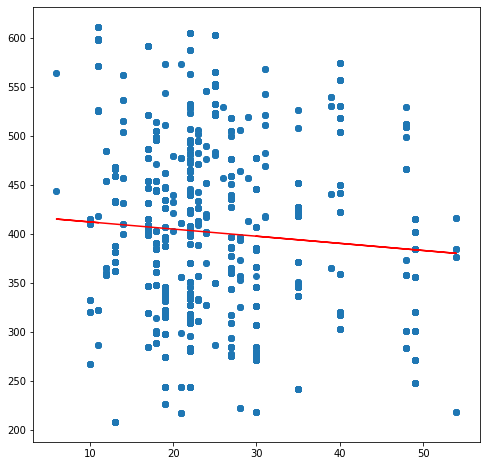

Coefficient: 
 -0.73
R-squared: 0.01


In [11]:
lin_reg_plot(spiro_pollution['PM2.5'],spiro_pollution['PEF(l/min)'])

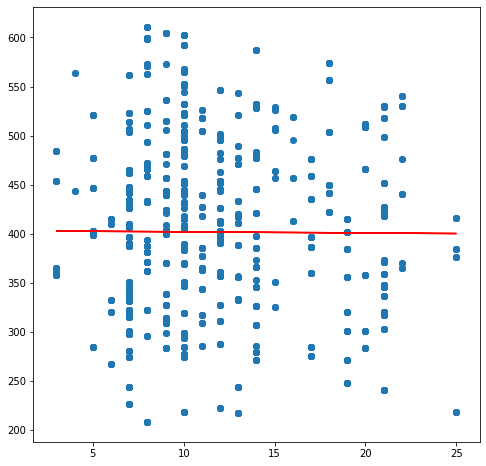

Coefficient: 
 -0.12
R-squared: 0.00


In [12]:
lin_reg_plot(spiro_pollution['PM10'],spiro_pollution['PEF(l/min)'])

In [13]:
pollution = pd.read_csv('pollution.csv',parse_dates=['date'])
pollution = pollution.rename(columns={"date": "Date"})
pollution.set_index('Date',inplace=True)
pollution = pollution.replace(' ','0')
pollution = pollution.astype('int64')

In [14]:
inhaler_days = pd.read_csv('inhaler_days.csv')
inhaler_days = inhaler_days.rename(columns={'Unnamed: 0':'Date'})
inhaler_days = inhaler_days.set_index('Date')
inhaler_days.head()

,first_reading,second_reading,difference
Date,,,
2020-03-02,218,416,198
2020-03-03,248,301,53
2020-03-04,218,274,56
2020-03-05,317,439,122
2020-03-07,280,441,161


In [ ]:
spiro_pollution = pollution.join(raw_spiro,how='inner')
spiro_pollution.head()

In [ ]:
Y = spiro_pollution['PEF(l/min)']
X = spiro_pollution[[' pm25',' o3',' no2',' co']]
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

In [17]:
lin_reg_plot(spiro_pollution[' no2'],spiro_pollution['PEF(l/min)'])

NameError: name 'lin_reg_plot' is not defined